# Z Test

- Reference [notebook](https://colab.research.google.com/drive/1hu-vJLeUHTQEn8fytWWRMiI2z-mtpIvS?usp=sharing)

In [1]:
# Built-in library
import re
import json
from typing import Any, Dict, List, Optional, Union
import logging
import warnings

# Standard imports
import numpy as np
import pandas as pd
import polars as pl
from rich import print

# import torch

# Visualization
import matplotlib.pyplot as plt


# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

warnings.filterwarnings("ignore")

# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy.stats import norm
from statsmodels.stats.weightstats import ztest

In [3]:
# Set seed
SEED: int = 123

np.random.seed(SEED)

In [4]:
N: int = 1_000
mu: int = 0.2
sigma: int = 1

# Generate random data from a standardnormal distribution
X: np.ndarray = np.random.randn(N) * sigma + mu

In [5]:
# Two-sided test
ztest(X)

(5.066899761724379, 4.043470672749927e-07)

## P-value Calculation

- Manual calculation

$$ p_{right} = 1 - \phi( |Z| ) $$
$$ p_{left} = \phi(-|Z| ) $$
$$ p = p_{left} + p_{right} $$
$$ Z = \frac{\hat{\mu} - \mu_{0}}{(\frac{\hat{\sigma}}{\sqrt{N}})} $$


where:

$ \phi $ => **Cummulative Density Function** (CDF)

In [6]:
# Two-sided test (Manual implementation)
mu_hat: float = X.mean()
sigma_hat: float = X.std(ddof=1)
z: float = mu_hat / (sigma_hat / np.sqrt(N))  # our mu0 = 0
p_right: float = 1 - norm.cdf(np.abs(z))
p_left: float = norm.cdf(-np.abs(z))
p: float = p_right + p_left
z, p

(5.066899761724379, 4.0434706732961455e-07)

In [7]:
# Alternate calculation (Manual implementation)
mu_0: float = 0.0
mu_hat: float = X.mean()
v_hat: float = X.var(ddof=1) / N
z: float = (mu_hat - mu_0) / np.sqrt(v_hat)
p: float = 2 * norm.sf(np.abs(z))
z, p

(5.066899761724379, 4.043470672749927e-07)

In [8]:
# One-sided test
ztest(X, alternative="larger")

(5.066899761724379, 2.0217353363749634e-07)

In [9]:
# One-sided test (Manual implementation)
mu_hat: float = X.mean()
sigma_hat: float = X.std(ddof=1)
z: float = (mu_hat - mu_0) / (sigma_hat / np.sqrt(N))  # our mu0 = 0
p: float = 1 - norm.cdf(z)
z, p

(5.066899761724379, 2.021735336921182e-07)

In [10]:
# Null under a different reference value
mu_0: float = 0.2
ztest(X, value=mu_0)

(-1.2495180739734475, 0.21147564705942012)

In [11]:
# Null under a different reference value (Manual implementation)
mu_hat = X.mean()
sigma_hat = X.std(ddof=1)
z = (mu_hat - mu_0) / (sigma_hat / np.sqrt(N))
p_right = 1 - norm.cdf(np.abs(z))
p_left = norm.cdf(-np.abs(z))
p = p_right + p_left
z, p

(-1.2495180739734475, 0.21147564705942012)

### Two-sample Test

In [12]:
# Two-sample test
N: int = 100
mu_0: float = 0.2
sigma_0: float = 1.0
X_0 = np.random.randn(N) * sigma_0 + mu_0

mu_1: float = 0.5
sigma_1: float = 1.0
X_1 = np.random.randn(N) * sigma_1 + mu_1

In [13]:
ztest(X_0, X_1)

(-2.3670272032230786, 0.017931614743417937)

In [14]:
# Two-sample test implementation
mu_hat0: float = X_0.mean()
mu_hat1: float = X_1.mean()

# Difference between the means
dmu_hat: float = mu_hat1 - mu_hat0
s2_hat0: float = X_0.var(ddof=1)
s2_hat1: float = X_1.var(ddof=1)

# Sum of standard deviations
s_hat: float = np.sqrt((s2_hat0 / N) + (s2_hat1 / N))
z: float = dmu_hat / s_hat  # reference value is 0

p_right: float = 1 - norm.cdf(np.abs(z))
p_left: float = norm.cdf(-np.abs(z))
p: float = p_right + p_left

z, p

(2.367027203223079, 0.01793161474341789)

## Load The Data

In [15]:
fp: str = "../../data/titanic_train.csv"
data: pl.DataFrame = pl.read_csv(source=fp)

data.head()

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
i64,i64,i64,str,str,f64,i64,i64,str,f64,str,str
1,0,3,"""Braund, Mr. Ow…","""male""",22.0,1,0,"""A/5 21171""",7.25,null,"""S"""
2,1,1,"""Cumings, Mrs. …","""female""",38.0,1,0,"""PC 17599""",71.2833,"""C85""","""C"""
3,1,3,"""Heikkinen, Mis…","""female""",26.0,0,0,"""STON/O2. 31012…",7.925,null,"""S"""
4,1,1,"""Futrelle, Mrs.…","""female""",35.0,1,0,"""113803""",53.1,"""C123""","""S"""
5,0,3,"""Allen, Mr. Wil…","""male""",35.0,0,0,"""373450""",8.05,null,"""S"""


### Hypothesis Test
 
#### Null Hypothesis ($H_{0}$)

- There is no significant difference in the mean fare prices between passengers who survived and passengers who did not survive.

#### Alternative Hypothesis ($H_{1}$)

- There is a significant difference in the mean fare prices between passengers who survived and passengers who did not survive.
  
- In mathematical notation:

$$H_{0} : \mu_{1} = \mu_{2} $$
​
$$H_{1} : \mu_{1} \neq \mu_{2} $$


In [16]:
X_1: np.ndarray = (
    data.filter(pl.col("Survived") == 0).select(pl.col("Fare")).to_numpy().flatten()
)
X_2: np.ndarray = (
    data.filter(pl.col("Survived") == 1).select(pl.col("Fare")).to_numpy().flatten()
)

In [17]:
import numpy.typing as npt

In [18]:
def calculate_delta_square(*, base_param: float, MDE: float = 0.15) -> float:
    param_2: float = base_param * (1 + MDE)
    delta_sqr: float = np.square(param_2 - base_param)
    return delta_sqr

In [19]:
calculate_delta_square(base_param=0.15, MDE=0.2)

0.0009

In [20]:
def calculate_num_samples(
    *,
    x_1: npt.NDArray[np.float_],
    x_2: npt.NDArray[np.float_],
    alpha: float = 0.05,
    power: float = 0.8,
    MDE: float = 0.1,
) -> int:
    """This is used to calculate the required number of samples for the 2 groups in an AB test.

    Params:
    -------
    x_1 (npt.NDArray[np.float_]): The control group data.
    x_2 (npt.NDArray[np.float_]): The treatment group data.
    alpha (float, default=0.05): The confidence threshold
    power (float, default=0.8): The statistical power.
    MDE (float, default= 0.10): Minimum Detectable Effect. i.e. relative lift.

    Returns:
    --------
    total_num_samples (float): The total number of sample size for the 2 groups.
    """
    from scipy.stats import norm

    # Calculate the z-critical score for a two-tailed test
    value: float = 1 - (alpha / 2)
    z_critical: float = np.round(norm.ppf(value), 2)

    # Calculate the Z(1 - beta) score
    z_score_power = norm.ppf(power)

    # Calculate the variance
    var_control: float = np.var(x_1, ddof=1)
    var_test: float = 2 * var_control
    base_param: float = np.mean(X_1)
    delta_sqr: float = calculate_delta_square(base_param=base_param, MDE=MDE)
    numerator: float = np.square(z_critical + z_score_power) * 2 * var_test

    total_num_samples: float = numerator / delta_sqr

    return np.round(total_num_samples)

In [21]:
calculate_num_samples(x_1=X_1, x_2=X_2, alpha=0.05, power=0.8, MDE=0.1)

6323.0

In [22]:
import seaborn as sns

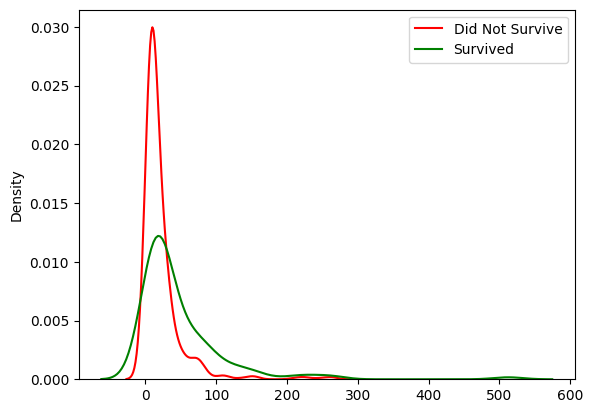

In [23]:
sns.kdeplot(X_1, label="Did Not Survive", color="red")
sns.kdeplot(X_2, label="Survived", color="green")
plt.legend()
plt.show()

In [24]:
X_1.shape, X_2.shape

((549,), (342,))

In [25]:
X_1.mean(), X_2.mean()

(22.117886885245902, 48.39540760233918)

In [26]:
test_statistic, p_val = ztest(X_1, X_2)
print(f"The p-value is: {p_val}")
print(
    "This implies that the mean fare prices of the 2 groups are statistically significant.\nDecision: REJECT the null hypothesis!"
)

The p-value is: 2.035031103573989e-15

This implies that the mean fare prices of the 2 groups are statistically significant.
Decision: REJECT the null hypothesis!